In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import csv
import numpy as np
import matplotlib.pyplot as plt
import math
import os
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from IPython.display import clear_output

torch.set_printoptions(threshold=float('inf'))
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["TORCH_USE_CUDA_DSA"] = "1"

device = "cuda:1"
address = fr"C:/Users/sjw00/OneDrive/Desktop/dataset/CIFAR_10"

temp_list = list()
r=open(address+'/training_data_CIFAR.csv', 'r' )
reader=csv.reader(r)
for i, target in enumerate(reader):
    temp_list.append(target)

training_data = np.array(temp_list).reshape((-1, 3, 32, 32)).astype(float)*2/255-1
training_data = torch.from_numpy(training_data).type(torch.FloatTensor).to(device)
print(training_data.shape, training_data.dtype)

batch_size = 800
training_dataset = TensorDataset(training_data)
training_dataloader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)


torch.Size([50000, 3, 32, 32]) torch.float32


In [2]:
def cosine_time_embedding(t, channels=256, max_period=10000):
    half_dim = channels // 2  # 사인-코사인을 위해 절반만 사용
    freqs = torch.exp(-torch.arange(half_dim).float() * (torch.log(torch.tensor(max_period)) / half_dim)).to(device)  # 주파수 계산

    # 🔹 t 값을 여러 주파수로 변환
    t_emb = t[:, None] * freqs[None, :]  # (batch, 128)

    # 🔹 사인-코사인 변환 적용 (256차원 벡터로 확장)
    t_emb = torch.cat([torch.sin(t_emb), torch.cos(t_emb)], dim=-1)  # (batch, 256)
    return t_emb  # 최종 시간 벡터 반환

class Diffusion:
    def __init__(self, T=1000):
        s=0.008
        steps = torch.linspace(0, T, T+1) / T  # 0~1 사이로 정규화
        f_t = (torch.cos((steps + s) / (1 + s) * (math.pi / 2)) ** 2).to(device)  # 코사인 제곱 함수 적용
        self.before_betas = (1 - f_t[1:] / f_t[:-1])
        self.betas = torch.clamp(self.before_betas, min=0.0001, max=0.02)  # 베타 값 계산 후 클리핑

        self.T = T  # 타임스텝 개수
        self.alphas = 1.0 - self.betas  # 알파 값 계산
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)  # 누적 알파
        self.sqrt_alpha_bar_t = torch.sqrt(self.alpha_bars)
        self.sqrt_one_minus_alpha_bar_t = torch.sqrt(1 - self.alpha_bars)
        self.variance = (1 - self.alpha_bars[:-1]) / (1 - self.alpha_bars[1:]) * self.betas[1:]
        self.sigma_t = torch.sqrt(self.variance)

    def forward_diffusion(self, x0, t):
        """ t 시점에서 x_t를 생성하는 과정 (노이즈 추가) """
        noise = torch.randn_like(x0, device=device) # [b, c, h, w]   
        return self.sqrt_alpha_bar_t[t][:, None, None, None] * x0 + self.sqrt_one_minus_alpha_bar_t[t][:, None, None, None] * noise, noise

    @torch.no_grad()
    def reverse_diffusion(self, model, img_size, num_samples=1):
        # 초기 상태: x_T ~ N(0, I) 에서 샘플링
        x_t = torch.randn((num_samples, *img_size), device=device)

        for t in reversed(range(0, self.T)):  # t=T부터 1까지 역순으로 실행
            t_tensor = torch.full((num_samples,), t, dtype=torch.long, device=device)
            
            # 모델을 통해 노이즈 예측 (예: U-Net)
            noise_pred = model(x_t, t_tensor)

            # 역방향 확산 공식 적용
            mean = (1 / torch.sqrt(self.alphas[t])) * (
                x_t - (self.betas[t] / self.sqrt_one_minus_alpha_bar_t[t]) * noise_pred
            )
            
            if t != 0:
                noise = torch.randn_like(x_t, device=device)  # 새로운 노이즈 샘플링
                x_t = mean + self.sigma_t[t-1] * noise
            else:
                x_t = mean  # 마지막 스텝에서는 노이즈 추가 X

        return x_t  # 최종적으로 x_0 반환
"""  
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.time_embedding_layer = torch.nn.Linear(256, 512)
        self.time_to_x = nn.Conv2d(512, 3, kernel_size=1)  # t_emb를 3채널로 변환
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2),  # 32x32 → 16x16
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2)   # 16x16 → 8x8
        )

        # 🔹 Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(1024, 512, kernel_size=3, padding=1),
            nn.LeakyReLU()
        )

        # 🔹 Decoder (업샘플링)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  # 8x8 → 16x16
            nn.LeakyReLU(),

            nn.ConvTranspose2d(256, 3, kernel_size=4, stride=2, padding=1),  # 16x16 → 32x32
            nn.LeakyReLU()
        )
    
    def forward(self, x, t):
        t_emb = cosine_time_embedding(t, 256)  # (batch, 256)
        t_emb = self.time_embedding_layer(t_emb)
        t_emb = t_emb[:, :, None, None]
        t_emb = self.time_to_x(t_emb)
        x = x + t_emb  # 시간 정보를 추가
        x = self.encoder(x)
        x = self.bottleneck(x)
        x = self.decoder(x)

        return x
"""

class DoubleConv(nn.Module):
    """(Conv2D -> GroupNorm -> SiLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.GroupNorm(8, out_channels),
            nn.SiLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.GroupNorm(8, out_channels),
            nn.SiLU(),
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, time_emb_dim=256):
        super(UNet, self).__init__()

        # 🔹 Time Embedding Layer
        self.time_mlp = nn.Sequential(
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.SiLU(),
            nn.Linear(time_emb_dim, 512)
        )

        # 🔹 Encoder (Downsampling)
        self.enc1 = DoubleConv(3, 256)  # 32x32
        self.enc2 = DoubleConv(256, 512)  # 16x16
        self.enc3 = DoubleConv(512, 1024)  # 8x8
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # 🔹 Bottleneck
        self.bottleneck1 = DoubleConv(1024, 512)  # 4x4
        self.bottleneck2 = DoubleConv(512, 1024)  # 4x4
        self.bottleneck3 = DoubleConv(1024, 1024)  # 4x4
        self.bottleneck4 = DoubleConv(1024, 1024)  # 4x4
        self.bottleneck5 = DoubleConv(1024, 1024)  # 4x4
        # 🔹 Decoder (Upsampling)
        self.upconv3 = nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1)  # 8x8
        self.dec3 = DoubleConv(1536, 512)

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1)  # 16x16
        self.dec2 = DoubleConv(768, 256)

        self.upconv1 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)  # 32x32
        self.dec1 = DoubleConv(384, 128)

        # 🔹 Final Output
        self.final_conv = nn.Conv2d(128, 3, kernel_size=1)  # (batch, 3, 32, 32)

    def forward(self, x, t):
        # 🔹 Time embedding
        t_emb = cosine_time_embedding(t, 256)  # (batch, 256)
        t_emb = self.time_mlp(t_emb).view(t.shape[0], 512, 1, 1)

        # 🔹 Encoder
        enc1 = self.enc1(x)  # 32x32
        enc2 = self.enc2(self.pool(enc1))  # 16x16
        enc3 = self.enc3(self.pool(enc2))  # 8x8

        # 🔹 Bottleneck
        bottleneck = self.bottleneck1(self.pool(enc3))  # 4x4
        bottleneck = bottleneck + t_emb  # 🔹 Time Embedding 추가
        bottleneck = self.bottleneck2(bottleneck)  # 4x4
        bottleneck = self.bottleneck3(bottleneck)  # 4x4
        bottleneck = self.bottleneck4(bottleneck)  # 4x4
        bottleneck = self.bottleneck5(bottleneck)  # 4x4
        # 🔹 Decoder
        up3 = self.upconv3(bottleneck)
        up3 = torch.cat([up3, enc3], dim=1)  # 🔹 Skip Connection
        up3 = self.dec3(up3)

        up2 = self.upconv2(up3)
        up2 = torch.cat([up2, enc2], dim=1)
        up2 = self.dec2(up2)

        up1 = self.upconv1(up2)
        up1 = torch.cat([up1, enc1], dim=1)
        up1 = self.dec1(up1)

        return self.final_conv(up1)


Epoch [3644/5000], Loss: 114.3266


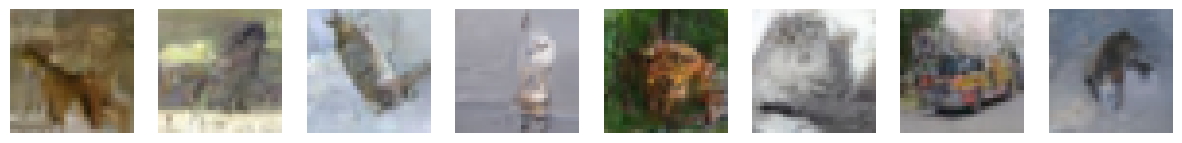

KeyboardInterrupt: 

In [3]:
model = UNet().to(device)
diffusion = Diffusion()
scaler = torch.amp.GradScaler()
# 옵티마이저 설정
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.5)
# 손실 함수
loss_fn = nn.MSELoss(reduction='sum')


# 학습 루프
num_epochs = 5000
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for x0, in training_dataloader:  # x0는 원본 이미지
        
        # 무작위 t 샘플링
        t = torch.randint(0, diffusion.T, (x0.shape[0],), device=device) # [batch_size]

        # x_t 생성
        x_t, noise = diffusion.forward_diffusion(x0, t)
        
        # 모델이 노이즈를 얼마나 잘 예측하는지 확인
        with torch.autocast(device_type='cuda', dtype=torch.bfloat16):
            noise_pred = model(x_t, t) # Forward pass: generate predictions
            loss = loss_fn(noise_pred, noise) # Compute the loss for the batch
        optimizer.zero_grad()
        scaler.scale(loss).backward() # Backpropagation: compute gradients
        scaler.step(optimizer) # Update model parameters using the optimizer
        epoch_loss+=loss.item() # Accumulate batch loss
        scaler.update() # Update the gradient scaler
    scheduler.step()
    average_loss = epoch_loss / 50000
    clear_output(wait=True)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}")

    img_size = (3, 32, 32)
    num_samples = 8

    # 모델을 평가 모드로 설정
    model.eval()

    with torch.no_grad():
        generated_images = diffusion.reverse_diffusion(model, img_size, num_samples)

    # 결과 시각화
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 15))
    for i, img in enumerate(generated_images):
        img = img.cpu().numpy().transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)
        img = (img + 1) / 2  # 정규화 해제 (-1~1 -> 0~1)
        img = np.clip(img, 0, 1)
        axes[i].imshow(img)
        axes[i].axis("off")
    plt.show()

In [ ]:
torch.save({
                'epoch': epoch + 1,
                'model': model.state_dict(),  
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                "scaler": scaler.state_dict(),
            }, fr"D:\model_save\epoch_{epoch}_{model.__class__.__name__}_{device[-1]}_{optimizer.param_groups[0]['lr']}.pt")

In [ ]:
model = UNet().to(device)
diffusion = Diffusion()
scaler = torch.amp.GradScaler()
# 옵티마이저 설정
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.5)
# 손실 함수
loss_fn = nn.MSELoss(reduction='sum')
print("Loading checkpoint...")

loadfilepath = fr"D:\model_save\epoch_1838_UNet_1_0.0005.pt" #D:\model_save\epoch_32_ResNet_0_71.758_0.0001.pt 1e-5 1e-4
lr = 1e-4

checkpoint = torch.load(loadfilepath, map_location=device)
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
scaler.load_state_dict(checkpoint['scaler'])
start_epoch = checkpoint['epoch']
print(f"Resuming from epoch {start_epoch}.")
optimizer.param_groups[0]['lr'] = lr
print(optimizer.param_groups[0]['lr'])

Loading checkpoint...


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_18504\3626571315.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(loadfilepath, map_locat

Resuming from epoch 1839.
0.0001


In [ ]:
num_epochs=5000
optimizer.param_groups[0]['lr'] = 1e-3
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for x0, in training_dataloader:  # x0는 원본 이미지
        
        # 무작위 t 샘플링
        t = torch.randint(0, diffusion.T, (x0.shape[0],), device=device) # [batch_size]

        # x_t 생성
        x_t, noise = diffusion.forward_diffusion(x0, t)
        
        # 모델이 노이즈를 얼마나 잘 예측하는지 확인
        with torch.autocast(device_type='cuda', dtype=torch.bfloat16):
            noise_pred = model(x_t, t) # Forward pass: generate predictions
            loss = loss_fn(noise_pred, noise) # Compute the loss for the batch
        optimizer.zero_grad()
        scaler.scale(loss).backward() # Backpropagation: compute gradients
        scaler.step(optimizer) # Update model parameters using the optimizer
        epoch_loss+=loss.item() # Accumulate batch loss
        scaler.update() # Update the gradient scaler
    scheduler.step()
    average_loss = epoch_loss / 50000
    clear_output(wait=True)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}")

    img_size = (3, 32, 32)
    num_samples = 8

    # 모델을 평가 모드로 설정
    model.eval()

    with torch.no_grad():
        generated_images = diffusion.reverse_diffusion(model, img_size, num_samples)

    # 결과 시각화
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 15))
    for i, img in enumerate(generated_images):
        img = img.cpu().numpy().transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)
        img = (img + 1) / 2  # 정규화 해제 (-1~1 -> 0~1)
        img = np.clip(img, 0, 1)
        
        
        axes[i].imshow(img)
        axes[i].axis("off")
    plt.show()

Epoch [139/5000], Loss: 85.5336
